# Question 1


Agent positions (row, column): [(3, 7), (6, 2), (6, 9), (0, 1)]
Destination positions (row, column): [(1, 5), (5, 8), (5, 1), (8, 4)]


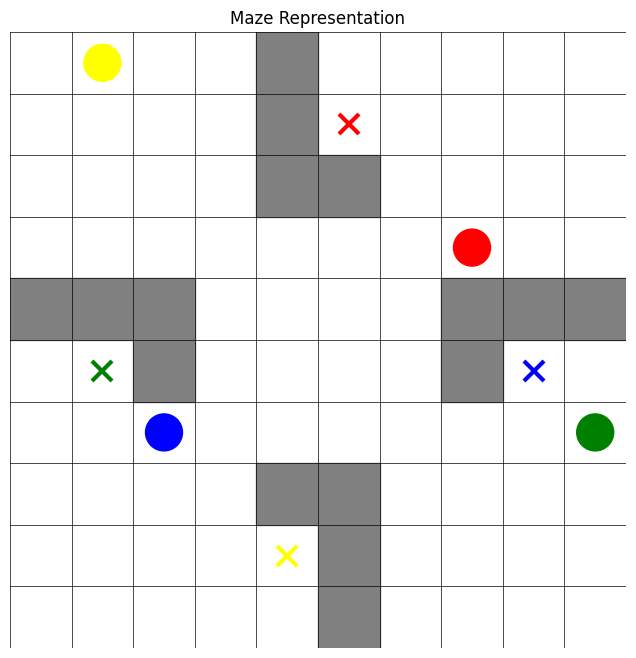

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import random
import numpy as np

maze_dim = 10
grid = np.zeros((maze_dim, maze_dim), dtype=int)

wall_positions = [
    (0, 4), (1, 4), (2, 4), (2, 5),
    (4, 7), (4, 8), (4, 9), (5, 7),
    (4, 0), (4, 1), (4, 2), (5, 2),
    (7, 5), (8, 5), (9, 5), (7, 4)
]
for pos in wall_positions:
    grid[pos] = 1

total_agents = 4
agent_positions = []
while len(agent_positions) < total_agents:
    row, col = random.randint(0, maze_dim-1), random.randint(0, maze_dim-1)
    if grid[row, col] == 0:
        agent_positions.append((row, col))
        grid[row, col] = 2

destination_points = [(1, 5), (5, 8), (5, 1), (8, 4)]
for point in destination_points:
    if grid[point] == 0:
        grid[point] = 3

print("\nAgent positions (row, column):", agent_positions)
print("Destination positions (row, column):", destination_points)

colors = ['red', 'blue', 'green', 'yellow']

def visualize_maze(grid, agents, destinations):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, maze_dim)
    ax.set_ylim(0, maze_dim)

    for r in range(maze_dim):
        for c in range(maze_dim):
            if grid[r, c] == 1:
                ax.add_patch(Rectangle((c, maze_dim-r-1), 1, 1, color='gray'))
            elif grid[r, c] == 2:
                agent_idx = agents.index((r, c))
                ax.add_patch(Circle((c+0.5, maze_dim-r-1+0.5), 0.3, color=colors[agent_idx]))
            elif grid[r, c] == 3:
                dest_idx = destinations.index((r, c))
                ax.plot(c+0.5, maze_dim-r-1+0.5, marker='x', color=colors[dest_idx], markersize=15, markeredgewidth=3)

    for i in range(maze_dim+1):
        ax.plot([0, maze_dim], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, maze_dim], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Maze Representation")
    plt.show()

visualize_maze(grid, agent_positions, destination_points)


In [21]:
import numpy as np
from collections import defaultdict

ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
ACTION_LABELS = ['Stay', 'Up', 'Down', 'Left', 'Right']
NUM_ACTIONS = len(ACTIONS)
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.1
EXPLORATION_RATE = 0.2
MAX_EPISODES = 500

class MultiAgentMaze:
    def __init__(self, maze, agent_positions, destination_positions):
        self.maze = maze
        self.agents = agent_positions
        self.destinations = destination_positions
        self.agent_count = len(agent_positions)
        self.state = tuple(agent_positions)
        self.steps = [0] * self.agent_count

    def is_valid(self, position):
        x, y = position
        return 0 <= x < maze_dim and 0 <= y < maze_dim and self.maze[x, y] != 1

    def reset(self):
        self.state = tuple(self.agents)
        self.steps = [0] * self.agent_count
        return self.state

    def step(self, actions):
        new_state = list(self.state)
        rewards = []
        for idx, action in enumerate(actions):
            current_pos = self.state[idx]
            move = ACTIONS[action]
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])
            if self.is_valid(new_pos) and new_pos not in new_state:
                new_state[idx] = new_pos
            self.steps[idx] += 1
            if new_pos == self.destinations[idx]:
                reward = 10
            else:
                reward = -1
            rewards.append(reward)
        self.state = tuple(new_state)
        done = all(new_state[i] == self.destinations[i] for i in range(self.agent_count))
        return self.state, rewards, done, max(self.steps)

def train_with_minmax(maze_env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(maze_env.agent_count)]
    best_max_time = float('inf')
    for episode in range(MAX_EPISODES):
        state = maze_env.reset()
        done = False
        while not done:
            actions = []
            for i in range(maze_env.agent_count):
                if np.random.rand() < EXPLORATION_RATE:
                    action = np.random.choice(NUM_ACTIONS)
                else:
                    action = np.argmax(q_tables[i][state[i]])
                actions.append(action)
            next_state, rewards, done, max_time = maze_env.step(actions)
            for i in range(maze_env.agent_count):
                current_q_value = q_tables[i][state[i]][actions[i]]
                max_future_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q_value + LEARNING_RATE * (
                    rewards[i] + DISCOUNT_FACTOR * max_future_q - current_q_value
                )
            state = next_state
        best_max_time = min(best_max_time, max_time)
    return q_tables, best_max_time

maze_env = MultiAgentMaze(grid, agent_positions, destination_points)
q_tables, best_max_time = train_with_minmax(maze_env)

print(f"\nBest maximum time achieved: {best_max_time}")



Best maximum time achieved: 11


In [23]:
def print_optimal_paths(maze_env, q_tables):
    for i in range(maze_env.agent_count):
        current_pos = maze_env.agents[i]
        destination = maze_env.destinations[i]
        path = [current_pos]
        while current_pos != destination:
            state = current_pos
            best_action_index = np.argmax(q_tables[i][state])
            move = ACTIONS[best_action_index]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])
            if maze_env.is_valid(next_pos):
                current_pos = next_pos
                path.append(current_pos)
            else:
                print(f"Invalid move encountered at {current_pos}. Exiting.")
                break
        print(f"\nAgent {i+1} : {path}")

print_optimal_paths(maze_env, q_tables)



Agent 1 : [(3, 7), (2, 7), (2, 6), (1, 6), (1, 5)]

Agent 2 : [(6, 2), (6, 3), (6, 4), (5, 4), (5, 5), (5, 6), (6, 6), (6, 7), (6, 8), (5, 8)]

Agent 3 : [(6, 9), (6, 8), (6, 7), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 1), (5, 1)]

Agent 4 : [(0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)]


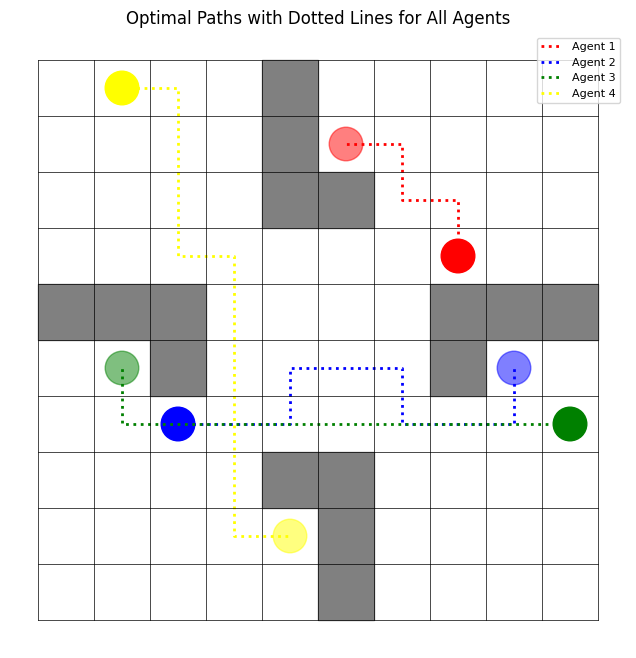

In [24]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def visualize_optimal_paths_with_dotted_lines(maze, maze_env, q_tables):
    path_grid = np.copy(maze)
    agent_colors = ['red', 'blue', 'green', 'yellow']
    fig, ax = plt.subplots(figsize=(8, 8))

    for x in range(maze_dim):
        for y in range(maze_dim):
            if maze[x, y] == 1:
                ax.add_patch(patches.Rectangle((y, maze_dim - x - 1), 1, 1, color='gray'))

    for i in range(4):
        current_pos = maze_env.agents[i]
        destination = maze_env.destinations[i]
        path_x, path_y = [], []

        path_x.append(current_pos[1] + 0.5)
        path_y.append(maze_dim - current_pos[0] - 1 + 0.5)

        while current_pos != destination:
            best_action_index = np.argmax(q_tables[i][current_pos])
            move = ACTIONS[best_action_index]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if maze_env.is_valid(next_pos):
                path_x.append(next_pos[1] + 0.5)
                path_y.append(maze_dim - next_pos[0] - 1 + 0.5)
                current_pos = next_pos
            else:
                print(f"Invalid move encountered for Agent {i+1} at {current_pos}.")
                break

        ax.plot(path_x, path_y, color=agent_colors[i], linestyle=':', linewidth=2, label=f'Agent {i+1}')
        ax.add_patch(patches.Circle((path_x[0], path_y[0]), 0.3, color=agent_colors[i]))
        ax.add_patch(patches.Circle((path_x[-1], path_y[-1]), 0.3, color=agent_colors[i], alpha=0.5))

    for i in range(maze_dim + 1):
        ax.plot([0, maze_dim], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, maze_dim], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    ax.legend(loc='upper right', fontsize=8)
    plt.title("Optimal Paths with Dotted Lines for All Agents")
    plt.show()

visualize_optimal_paths_with_dotted_lines(grid, maze_env, q_tables)


# Question 2


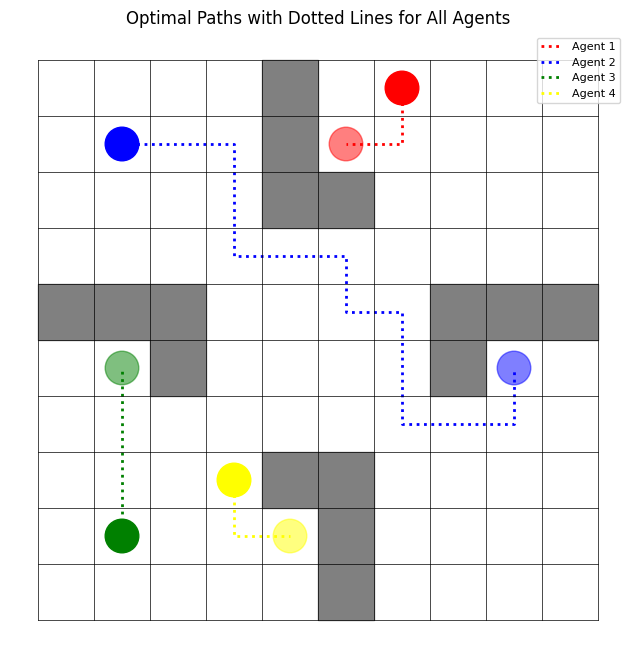

In [26]:
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
NUM_ACTIONS = len(ACTIONS)
GAMMA = 0.9
ALPHA = 0.1
EPSILON = 0.2
MAX_EPISODES = 500

wall_positions = [
    (0, 4), (1, 4), (2, 4), (2, 5),
    (4, 7), (4, 8), (4, 9), (5, 7),
    (4, 0), (4, 1), (4, 2), (5, 2),
    (7, 5), (8, 5), (9, 5), (7, 4)
]

class MultiAgentMazeMAPF:
    def __init__(self, maze, destinations):
        self.maze = maze
        self.destinations = destinations
        self.num_agents = len(destinations)
        self.maze_size = len(maze)
        self.state = None
        self.steps = [0] * self.num_agents
        self.reset()

    def is_valid_position(self, pos):
        x, y = pos
        return 0 <= x < self.maze_size and 0 <= y < self.maze_size and self.maze[x, y] != 1

    def reset(self):
        self.agents = []
        while len(self.agents) < self.num_agents:
            x, y = random.randint(0, self.maze_size - 1), random.randint(0, self.maze_size - 1)
            if self.is_valid_position((x, y)) and (x, y) not in self.agents:
                self.agents.append((x, y))
        self.state = tuple(self.agents)
        self.steps = [0] * self.num_agents
        return self.state

    def step(self, actions):
        next_state = list(self.state)
        rewards = []
        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])
            if self.is_valid_position(new_pos) and new_pos not in next_state:
                next_state[i] = new_pos
            reward = 10 if next_state[i] == self.destinations[i] else -1
            rewards.append(reward)
            self.steps[i] += 1
        self.state = tuple(next_state)
        done = all(next_state[i] == self.destinations[i] for i in range(self.num_agents))
        return self.state, rewards, done, max(self.steps)

def train_agents_mapf(maze_env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(maze_env.num_agents)]
    best_max_time = float('inf')
    for episode in range(MAX_EPISODES):
        state = maze_env.reset()
        done = False
        while not done:
            actions = []
            for i in range(maze_env.num_agents):
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)
                else:
                    action = np.argmax(q_tables[i][state[i]])
                actions.append(action)
            next_state, rewards, done, max_time = maze_env.step(actions)
            for i in range(maze_env.num_agents):
                current_q = q_tables[i][state[i]][actions[i]]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )
            state = next_state
        best_max_time = min(best_max_time, max_time)
    return q_tables, best_max_time

def visualize_optimal_paths_with_dotted_lines(maze, maze_env, q_tables):
    agent_colors = ['red', 'blue', 'green', 'yellow']
    fig, ax = plt.subplots(figsize=(8, 8))
    for x in range(len(maze)):
        for y in range(len(maze)):
            if maze[x, y] == 1:
                ax.add_patch(patches.Rectangle((y, len(maze) - x - 1), 1, 1, color='gray'))
            elif maze[x, y] == 3:
                agent_index = maze_env.destinations.index((x, y))
                color = agent_colors[agent_index]
                ax.plot(y + 0.5, len(maze) - x - 1 + 0.5, marker='x', color=color, markersize=15, markeredgewidth=3)
    for i in range(maze_env.num_agents):
        current_pos = maze_env.agents[i]
        destination = maze_env.destinations[i]
        path_x, path_y = [], []
        path_x.append(current_pos[1] + 0.5)
        path_y.append(len(maze) - current_pos[0] - 1 + 0.5)
        while current_pos != destination:
            best_action_index = np.argmax(q_tables[i][current_pos])
            move = ACTIONS[best_action_index]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])
            if maze_env.is_valid_position(next_pos):
                path_x.append(next_pos[1] + 0.5)
                path_y.append(len(maze) - next_pos[0] - 1 + 0.5)
                current_pos = next_pos
            else:
                break
        ax.plot(path_x, path_y, color=agent_colors[i], linestyle=':', linewidth=2, label=f'Agent {i+1}')
        ax.add_patch(patches.Circle((path_x[0], path_y[0]), 0.3, color=agent_colors[i]))
        ax.add_patch(patches.Circle((path_x[-1], path_y[-1]), 0.3, color=agent_colors[i], alpha=0.5))
    for i in range(len(maze) + 1):
        ax.plot([0, len(maze)], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, len(maze)], color='black', linewidth=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.legend(loc='upper right', fontsize=8)
    plt.title("Optimal Paths with Dotted Lines for All Agents")
    plt.show()

maze_dim = 10
maze = np.zeros((maze_dim, maze_dim), dtype=int)
for (x, y) in wall_positions:
    maze[x, y] = 1
destinations = [(1, 5), (5, 8), (5, 1), (8, 4)]
maze_env = MultiAgentMazeMAPF(maze, destinations)
q_tables, min_max_time = train_agents_mapf(maze_env)
visualize_optimal_paths_with_dotted_lines(maze, maze_env, q_tables)
